In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from pathlib import Path

sns.set(context="notebook")

In [51]:
X_linear = pd.read_csv("../data/customer_snapshot_Xlinear.csv")  # numeric features; no churn/ID
X = X_linear.select_dtypes(include=[np.number]).copy()
X = X.fillna(X.median(numeric_only=True))



In [52]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [53]:
ks = range(2, 11)
baseline_sil = []
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=30, max_iter=500)
    labels = km.fit_predict(X_scaled)
    baseline_sil.append(silhouette_score(X_scaled, labels))

# --- PCA grid: n_components x k ---
max_pcs = min(X.shape[1], 20)  # keep it practical
pc_list = [2, 3, 4, 5, 6, 8, 10, max_pcs] if max_pcs not in [2,3,4,5,6,8,10] else [2,3,4,5,6,8,10]
pc_list = sorted(set([p for p in pc_list if p <= max_pcs]))

sil_grid = pd.DataFrame(index=pc_list, columns=ks, dtype=float)
evr = {}  # explained variance ratio per n_components

for n_pc in pc_list:
    pca = PCA(n_components=n_pc, random_state=42, whiten=False)
    X_pca = pca.fit_transform(X_scaled)
    evr[n_pc] = pca.explained_variance_ratio_.sum()
    for k in ks:
        km = KMeans(n_clusters=k, random_state=42, n_init=30, max_iter=500)
        labels = km.fit_predict(X_pca)
        sil_grid.loc[n_pc, k] = silhouette_score(X_pca, labels)

best_pc, best_k = np.unravel_index(np.nanargmax(sil_grid.values), sil_grid.shape)
best_pc = sil_grid.index[best_pc]
best_k = sil_grid.columns[best_k]
best_sil = sil_grid.loc[best_pc, best_k]

print("Baseline (no PCA) best silhouette:")
print(pd.Series(baseline_sil, index=ks).round(4))
print("\nBest PCA combo → n_components =", best_pc, 
      "| k =", best_k, 
      "| silhouette =", round(best_sil, 4), 
      "| explained variance =", f"{evr[best_pc]*100:.1f}%")

Baseline (no PCA) best silhouette:
2     0.0967
3     0.0754
4     0.0822
5     0.0755
6     0.0805
7     0.0844
8     0.0898
9     0.0822
10    0.0843
dtype: float64

Best PCA combo → n_components = 2 | k = 8 | silhouette = 0.3797 | explained variance = 23.9%


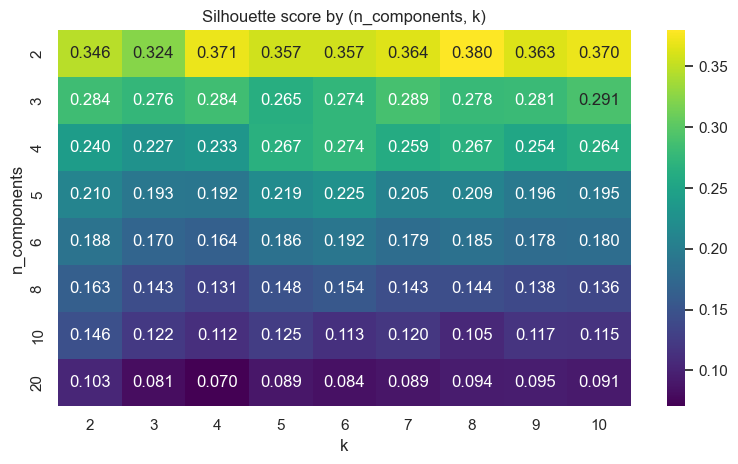

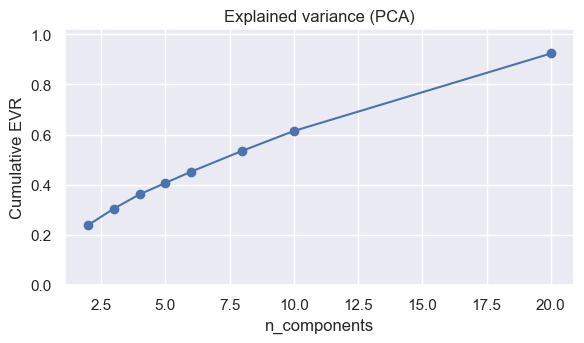

In [54]:
plt.figure(figsize=(8, 4.8))
sns.heatmap(sil_grid, annot=True, fmt=".3f", cmap="viridis")
plt.title("Silhouette score by (n_components, k)")
plt.xlabel("k"); plt.ylabel("n_components")
plt.tight_layout(); plt.show()

# --- elbow of explained variance (just for context) ---
plt.figure(figsize=(6, 3.6))
plt.plot(list(evr.keys()), [evr[p] for p in evr.keys()], marker="o")
plt.title("Explained variance (PCA)")
plt.xlabel("n_components"); plt.ylabel("Cumulative EVR")
plt.ylim(0, 1.02); plt.grid(True); plt.tight_layout(); plt.show()

In [55]:
BEST_K = 4

Final clustering: k=5 | n_components=2 | silhouette=0.3569


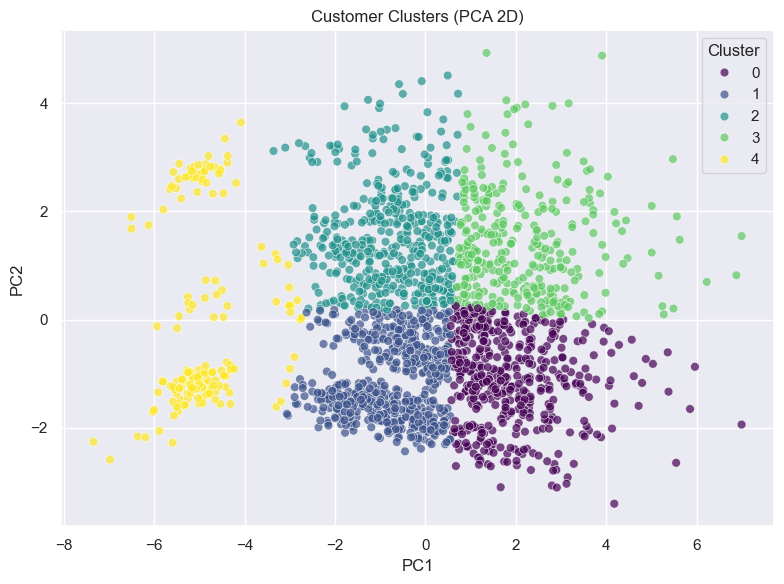

In [56]:
# --- Final clustering with k=5 and n_components=2 ---
pca_final = PCA(n_components=2, random_state=42, whiten=False)
X_pca_final = pca_final.fit_transform(X_scaled)
kmeans_final = KMeans(n_clusters=5, random_state=42, n_init=30, max_iter=500)
labels_final = kmeans_final.fit_predict(X_pca_final)
sil_final = silhouette_score(X_pca_final, labels_final)
print(f"Final clustering: k=5 | n_components=2 | silhouette={sil_final:.4f}")

# --- Visualize clusters in PCA 2D space ---
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca_final[:,0], y=X_pca_final[:,1], hue=labels_final, palette='viridis', s=40, alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Customer Clusters (PCA 2D)')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

In [ ]:
X_linear['cluster'] = labels_final 
if 'customer_id' in X_linear.columns:
    cluster_map = X_linear[['customer_id', 'cluster']]
    cluster_map.to_csv('../data/customer_clusters.csv', index=False)
    print('Saved cluster assignments to customer_clusters.csv')



Saved cluster assignments to customer_clusters.csv


/var/folders/fs/mddyrysx4g54qhj4jmw3k0f40000gn/T/ipykernel_32286/1331041166.py:55: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aux_tbl  = prof.groupby("cluster").apply(_dominant_category)


ValueError: If using all scalar values, you must pass an index

=== Cluster Analysis Report (Named) ===
Total customers: 1,967

>> Segment summary (sizes & key means)
   cluster                                 segment_name    n  share  orders  \
1        1        Dormant Regulars (Disengaged/Neutral)  559  0.284    3.17   
0        0                   Cooling Regulars (At-Risk)  458  0.233    5.83   
2        2  Discontent Dormant (High Negative Feedback)  446  0.227    3.11   
3        3                                    VIP Loyal  338  0.172    5.88   
4        4                  One-Timer / Lapsed Episodic  166  0.084    1.11   

   recency_days  tenure_days  monetary_sum  monetary_per_30d       aov  \
1        409.92       667.19     176484.17          12930.26  57625.35   
0        205.42      1043.26     372594.54          11410.14  65113.70   
2        392.73       672.85     152705.04          13203.54  50208.06   
3        160.80      1108.24     341397.49           9985.37  59139.06   
4        719.51         8.43      57903.01        14

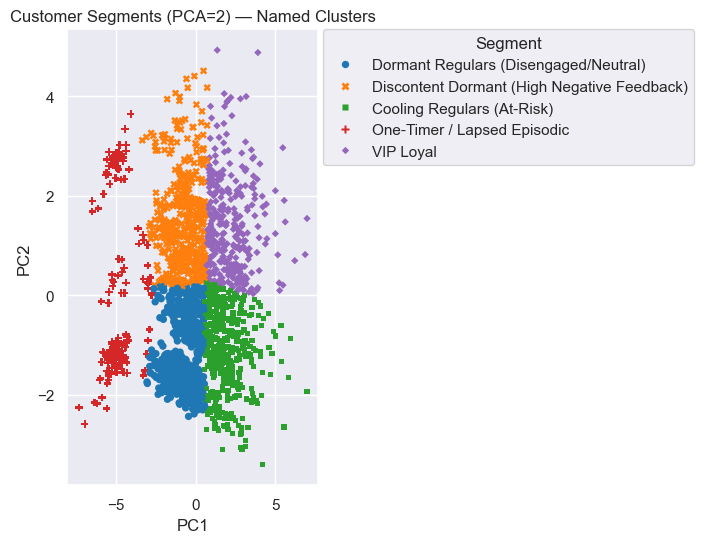


Saved with segment names → ../data/customer_snapshot_with_named_segments.csv


In [60]:
# === Final Cluster Analysis + Named PCA Plot (k=5, n=2) ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sns.set(context="notebook")

# ---- Load inputs ----
snap = pd.read_csv("../data/customer_snapshot_ml.csv")
labels_df = pd.read_csv("../data/customer_clusters.csv")            # must have 'cluster'
Xlinear = pd.read_csv("../data/customer_snapshot_Xlinear.csv")      # numeric features used in clustering (for PCA plot)

assert "cluster" in labels_df.columns, "customer_clusters.csv must contain a 'cluster' column."

# Attach cluster labels (prefer join by customer_id; else align by row order)
if "customer_id" in snap.columns and "customer_id" in labels_df.columns:
    snap = snap.merge(labels_df[["customer_id","cluster"]], on="customer_id", how="left", validate="one_to_one")
else:
    assert len(snap) == len(labels_df), "Row mismatch; include customer_id in both files or ensure row order is aligned."
    snap = snap.copy()
    snap["cluster"] = labels_df["cluster"].values

# ---- Map cluster IDs -> final segment names (based on your posted report) ----
# If you re-cluster and IDs change, update this mapping.
cluster_name_map = {
    3: "VIP Loyal",
    2: "Discontent Dormant (High Negative Feedback)",
    0: "Cooling Regulars (At-Risk)",
    1: "Dormant Regulars (Disengaged/Neutral)",
    4: "One-Timer / Lapsed Episodic",
}
snap["segment_name"] = snap["cluster"].map(cluster_name_map).fillna(snap["cluster"].astype(str))

# ---- Derived fields used ONLY for reporting (not changing your data) ----
eps = 1e-9
if {"sent_pos","sent_neg"}.issubset(snap.columns):
    snap["neg_rate"] = snap["sent_neg"] / (snap["sent_pos"] + snap["sent_neg"] + eps)
else:
    snap["neg_rate"] = np.nan

# ---- Build report tables ----
sizes = snap.groupby(["cluster","segment_name"]).size().rename("n")
share = (sizes / len(snap)).round(3)

report_cols = [
    "orders","recency_days","tenure_days",
    "monetary_sum","monetary_per_30d","aov","orders_per_30d",
    "top_category_share","neg_rate","churn"
]
have = [c for c in report_cols if c in snap.columns]

means = snap.groupby(["cluster","segment_name"])[have].mean().round(2)
meds  = snap.groupby(["cluster","segment_name"])[have].median().round(2)

summary = (
    pd.concat([sizes, share.rename("share"), means], axis=1)
      .reset_index()
      .sort_values("n", ascending=False)
)

# ---- Print analysis report ----
pd.set_option("display.max_columns", None)
print("=== Cluster Analysis Report (Named) ===")
print(f"Total customers: {len(snap):,}\n")

print(">> Segment summary (sizes & key means)")
cols_to_show = ["cluster","segment_name","n","share"] + have
print(summary[cols_to_show].fillna("N/A"))

print("\n--- One-liners ---")
for _, r in summary.sort_values("cluster").iterrows():
    cl = int(r["cluster"])
    nm = r["segment_name"]
    print(
        f"[Cluster {cl}] {nm} "
        f"(n={int(r['n'])}, {r['share']*100:.1f}%) — "
        f"recency={r.get('recency_days',np.nan):.0f}d, "
        f"orders={r.get('orders',np.nan):.2f}, "
        f"AOV={r.get('aov',np.nan):.0f}, "
        f"orders/30d={r.get('orders_per_30d',np.nan):.2f}, "
        f"monetary/30d={r.get('monetary_per_30d',np.nan):.0f}, "
        f"churn={r.get('churn',np.nan):.2%}"
    )

print("\n>> Medians (robust view)")
print(meds)

# ---- PCA scatter with named legend (for visualization only) ----
# Use Xlinear (numeric), scale, PCA(2); color by named segment
X = Xlinear.select_dtypes(include=[np.number]).copy()
X = X.fillna(X.median(numeric_only=True))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
XY = pca.fit_transform(X_scaled)

plot_df = pd.DataFrame({
    "pc1": XY[:,0],
    "pc2": XY[:,1],
    "cluster": snap["cluster"].values,
    "segment_name": snap["segment_name"].values
})

plt.figure(figsize=(7.2, 5.6))
palette = sns.color_palette("tab10", n_colors=plot_df["segment_name"].nunique())
sns.scatterplot(
    data=plot_df,
    x="pc1", y="pc2",
    hue="segment_name",
    style="segment_name",
    s=28, edgecolor="none", palette=palette
)
plt.title("Customer Segments (PCA=2) — Named Clusters")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(title="Segment", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
plt.tight_layout()
plt.show()

# (Optional) Save a copy with names attached
out_path = "../data/customer_snapshot_with_named_segments.csv"
snap.to_csv(out_path, index=False)
print(f"\nSaved with segment names → {out_path}")
